# Interdisciplinary Project
The goal of the project is to improve the visualization of flood data, which represents its evolution over time, to facilitate a deeper comprehension of flood dynamics for different target audiences. The main tasks include: researching best practices in dynamic data visualization, preparing and processing satellite data, evaluating different visualization methods, proposing and implementing various visualization techniques for different target audiences and use cases, and optimizing performance for large-scale and/or high-resolution datasets.

In [1]:
import hvplot.xarray
import pystac_client
from odc import stac as odc_stac
from dask.distributed import wait
from dask.distributed import Client, wait


### Dask
Dask is a python library designed for parallel computing. More details [here](https://www.dask.org/).

In [2]:
# set up dask client for paralelized computation
client = Client(processes=False, threads_per_worker=2, n_workers=3, memory_limit="12GB")

# Connect to STAC catalog
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1/")

c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54241 instead
  warnings.warn(


## Use-case

The flooded area chosen for this project is around the city of Zingst, at the Baltic coast of Nothern Germany. The area was affected by the storm 'Babet' at the 20th of October 2023. More details about the event [here](https://en.wikipedia.org/wiki/Storm_Babet).  Below, the year 2022 is shown instead, as there is currently a error whithin the collection, but it should be fixed soon.

### Define the area and time range

In [3]:
# we define the time range of the event and coordinates of the area with the bounding_box
time_range = "2022-10-11/2022-10-25"
time_range = "2023-10-11/2023-10-25"
minlon, maxlon = 12.3, 13.1
minlat, maxlat = 54.3, 54.6
bounding_box = [minlon, minlat, maxlon, maxlat]

### Get the images for the defined area and time range

In [4]:
# inside the EODC catalogue we get the GFM collection (Global Flood Monitoring) https://services.eodc.eu/browser/#/v1/collections/GFM?.language=en
search = eodc_catalog.search(collections="GFM", bbox=bounding_box, datetime=time_range)
items_GFM = search.item_collection()

print(f"Found {len(items_GFM)} items") 

Found 37 items


### Inspect the items proprieties

In [5]:
items_GFM[0].properties

{'gsd': 20,
 'created': '2024-10-29T12:11:45.979215+00:00',
 'datetime': '2023-10-25T05:17:47Z',
 'Equi7Tile': 'EU020M_E051N021T3',
 'blocksize': {'x': 512, 'y': 512},
 'proj:bbox': [5100000, 2100000, 5400000, 2400000],
 'proj:wkt2': 'PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]',
 'proj:shape': [15000, 15000],
 'constellation': 'sentinel-1',
 'flood_members': {'DLR': True, 'TUW': True, 'LIST': True},
 'proj:geometry': {'type': 'Polygon',
  'coordinates': [[[5100000.0, 2100000.0],
    [5100000.0, 2400000.0],
    [5400000.0, 2400000.0],
    [5400000.0, 2100000.0],
    [

### Load the data cube

In [6]:
import pyproj
crs = pyproj.CRS.from_wkt(items_GFM[0].properties["proj:wkt2"])

# Set the resolution of the data
resolution = items_GFM[0].properties['gsd']

GFM_dc= odc_stac.load(
    items_GFM, 
    bbox=bounding_box,   # Define the bounding box for the area of interest
    crs=crs,   # Set the coordinate reference system
    #bands=["tuw_likelihood","tuw_flood_extent"],   # Specify the bands to load, comment to load all bands
    resolution=resolution,   # Set the resolution of the data
    dtype='uint8',   # Define the data type
    chunks={"x": 1000, "y": 1000, "time": -1},  # Set the chunk size for Dask
)

GFM_dc = GFM_dc.persist()
wait(GFM_dc)

GFM_dc

<xarray.Dataset> Size: 2GB
Dimensions:                (y: 2064, x: 2829, time: 28)
Coordinates:
  * y                      (y) float64 17kB 2.362e+06 2.362e+06 ... 2.32e+06
  * x                      (x) float64 23kB 5.079e+06 5.079e+06 ... 5.136e+06
    spatial_ref            int32 4B 27704
  * time                   (time) datetime64[ns] 224B 2023-10-11T05:33:18 ......
Data variables:
    advisory_flags         (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    dlr_likelihood         (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    exclusion_mask         (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    tuw_likelihood         (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    list_likelihood        (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    dlr_flood_extent       (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    tuw_flood_extent       (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    list_flood_extent      (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    ensemble_likelihood    (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    reference_water_mask   (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    ensemble_flood_extent  (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>
    ensemble_water_extent  (time, y, x) uint8 163MB dask.array<chunksize=(28, 1000, 1000), meta=np.ndarray>

In [7]:
# Describe the range of values for each data variable in GFM_dc
import numpy as np
for var in GFM_dc.data_vars:
    data = GFM_dc[var].values
    valid_data = data[~np.isnan(data)]
    min_val = np.nanmin(valid_data)
    max_val = np.nanmax(valid_data)
    print(f"{var}: min={min_val}, max={max_val}")

advisory_flags: min=0, max=255
dlr_likelihood: min=0, max=255
exclusion_mask: min=0, max=255
tuw_likelihood: min=0, max=255
list_likelihood: min=0, max=255
dlr_flood_extent: min=0, max=255
tuw_flood_extent: min=0, max=255
list_flood_extent: min=0, max=255
ensemble_likelihood: min=0, max=255
reference_water_mask: min=0, max=255
ensemble_flood_extent: min=0, max=255
ensemble_water_extent: min=0, max=255


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_variable_distributions(data_cube):
    # Set up the figure size
    n_vars = len(data_cube.data_vars)
    fig, axes = plt.subplots(n_vars, 1, figsize=(12, 4*n_vars))
    fig.suptitle('Distribution of Variables in GFM Dataset', fontsize=16)
    
    # Plot distribution for each variable
    for idx, (var_name, ax) in enumerate(zip(data_cube.data_vars, axes)):
        # Get data and remove 255 values (no data)
        data = data_cube[var_name].values.flatten()
        data = data[data != 255]
        
        # Create distribution plot
        sns.histplot(data, bins=50, ax=ax)
        ax.set_title(f'{var_name} Distribution')
        ax.set_xlabel('Value')
        ax.set_ylabel('Count')
        
        # Add statistical information
        stats = f'Mean: {np.mean(data):.2f}\nStd: {np.std(data):.2f}'
        ax.text(0.95, 0.95, stats,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

# Create and display the distribution plots
#distribution_plot = plot_variable_distributions(GFM_dc)
#plt.show()

Generating distribution plots...


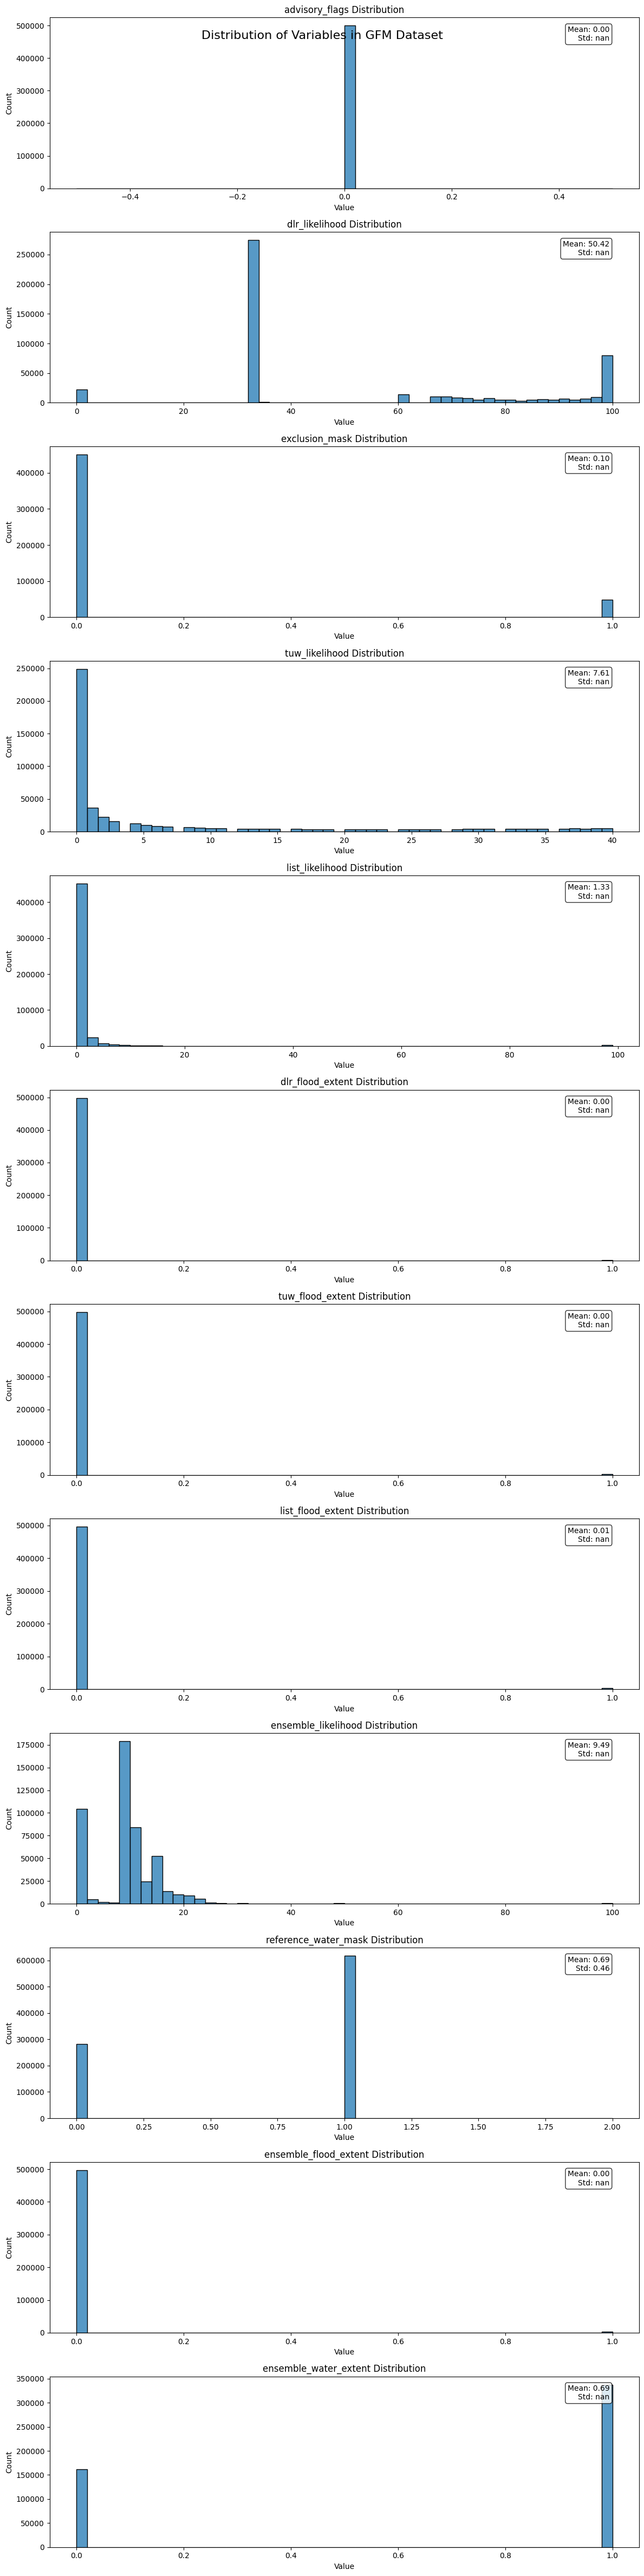

In [9]:
def plot_variable_distributions_optimized(data_cube):
    n_vars = len(data_cube.data_vars)
    fig, axes = plt.subplots(n_vars, 1, figsize=(12, 4*n_vars))
    fig.suptitle('Distribution of Variables in GFM Dataset', fontsize=16)
    
    # Make axes iterable if there's only one variable
    if n_vars == 1:
        axes = [axes]
    
    for idx, (var_name, ax) in enumerate(zip(data_cube.data_vars, axes)):
        # Use dask computation
        data = data_cube[var_name].data
        
        # Compute statistics using dask
        valid_data = data[data != 255]
        mean = float(valid_data.mean().compute())
        std = float(valid_data.std().compute())
        
        # Sample data for histogram (faster)
        sample_size = min(100000, valid_data.size)
        sample_data = valid_data.map_blocks(lambda x: np.random.choice(x.flatten(), 
                                          size=min(sample_size, x.size))).compute()
        
        # Plot
        sns.histplot(sample_data, bins=50, ax=ax)
        ax.set_title(f'{var_name} Distribution')
        ax.set_xlabel('Value')
        ax.set_ylabel('Count')
        
        # Add stats
        stats = f'Mean: {mean:.2f}\nStd: {std:.2f}'
        ax.text(0.95, 0.95, stats,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

# Create and display the plots with progress indication
print("Generating distribution plots...")
distribution_plot = plot_variable_distributions_optimized(GFM_dc)
plt.show()

In [47]:
data_variable_names = list(GFM_dc.data_vars)
print(data_variable_names)
duplicate_variables = [var for var in data_variable_names if GFM_dc[var].equals(GFM_dc[data_variable_names[0]])]
print(f"Duplicate variables: {duplicate_variables}")
if duplicate_variables:
    duplicate_reference = GFM_dc[duplicate_variables[0]]
    print(f"The duplicate variable '{duplicate_variables[0]}' is identical to the reference variable:\n{duplicate_reference}")
else:
    print("No duplicates found.")


['advisory_flags', 'dlr_likelihood', 'exclusion_mask', 'tuw_likelihood', 'list_likelihood', 'dlr_flood_extent', 'tuw_flood_extent', 'list_flood_extent', 'ensemble_likelihood', 'reference_water_mask', 'ensemble_flood_extent', 'ensemble_water_extent']
Duplicate variables: ['advisory_flags']
The duplicate variable 'advisory_flags' is identical to the reference variable:
<xarray.DataArray 'advisory_flags' (time: 28, y: 2064, x: 2829)> Size: 163MB
dask.array<advisory_flags, shape=(28, 2064, 2829), dtype=uint8, chunksize=(28, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 17kB 2.362e+06 2.362e+06 ... 2.32e+06 2.32e+06
  * x            (x) float64 23kB 5.079e+06 5.079e+06 ... 5.135e+06 5.136e+06
    spatial_ref  int32 4B 27704
  * time         (time) datetime64[ns] 224B 2023-10-11T05:33:18 ... 2023-10-2...
Attributes:
    nodata:   255


In [48]:
from scipy.stats import pearsonr
import numpy as np

# Pre-processing
# Substitute 255 for NaNs
GFM_dc["tuw_flood_extent"] = GFM_dc.tuw_flood_extent.where(GFM_dc.tuw_flood_extent!=255).compute()
GFM_dc["tuw_likelihood"] = GFM_dc.tuw_likelihood.where(GFM_dc.tuw_likelihood!=255).compute()

# Compute similarity between flood extent and likelihood for each time step

# Flatten the arrays and mask NaNs for valid comparison
extent = GFM_dc["tuw_flood_extent"].values
likelihood = GFM_dc["tuw_likelihood"].values

similarities = []
for t in range(extent.shape[0]):
    ext_flat = extent[t].flatten()
    lik_flat = likelihood[t].flatten()
    mask = ~np.isnan(ext_flat) & ~np.isnan(lik_flat)
    if np.any(mask):
        corr, _ = pearsonr(ext_flat[mask], lik_flat[mask])
        similarities.append(corr)
    else:
        similarities.append(np.nan)

print("Pearson correlation (similarity) for each time step:", similarities)

C:\Users\jonas\AppData\Local\Temp\ipykernel_1820\1774254466.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(ext_flat[mask], lik_flat[mask])


Pearson correlation (similarity) for each time step: [-0.035059996, nan, nan, nan, nan, 0.010943129, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.006512488, nan, nan, nan, nan, -0.08038394, nan, nan, nan, nan, 0.022443155, nan, nan]


### Visulize the data



### Import the color scheme

In [10]:
import sys
sys.path.append('c:/Users/jonas/Desktop/Tu-Wien/Semester_4/Project/RemoteSensing-InterdisciplinaryProject/dynamic-flood-visualization/src')
from color_schemes import get_color_scheme, list_available_schemes

print("Available color schemes:")
schemes = list_available_schemes()
print(schemes)

Available color schemes:
['blue_to_red', 'green_to_brown', 'white_to_blue', 'purple_to_yellow', 'red_to_blue_diverging', 'solid_black', 'blue_to_red_extended', 'light_to_strong_blue']


In [11]:
band_name = "reference_water_mask"
print(f"Visualizing band: {band_name}")

colors = get_color_scheme('blue_to_red')
GFM_dc[band_name].hvplot.image(
    x="x", 
    y="y", 
    title=f"{band_name}",
    cmap=colors,
    clim=(0, 100),
    width=800,
    height=600,
    colorbar=True
)

Visualizing band: reference_water_mask


BokehModel(combine_events=True, render_bundle={'docs_json': {'07489aeb-b3f7-4eae-9157-9ecefbe9ba3c': {'version…

In [14]:
band_name = "tuw_flood_extent"
print(f"Visualizing band: {band_name}")

colors = get_color_scheme('green_to_brown')
GFM_dc[band_name].hvplot.image(
    x="x", 
    y="y", 
    title=f"{band_name}",
    cmap=colors,
    clim=(0, 100),
    width=800,
    height=600,
    colorbar=True
)

Visualizing band: tuw_flood_extent


BokehModel(combine_events=True, render_bundle={'docs_json': {'3ece4311-7f0f-4b3a-818d-0f6388101a9a': {'version…

In [15]:
band_name = "tuw_flood_extent"
print(f"Visualizing band: {band_name}")

colors = get_color_scheme('white_to_blue')
GFM_dc[band_name].hvplot.image(
    x="x", 
    y="y", 
    title=f"{band_name}",
    cmap=colors,
    clim=(0, 100),
    width=800,
    height=600,
    colorbar=True
)

Visualizing band: tuw_flood_extent


BokehModel(combine_events=True, render_bundle={'docs_json': {'df08f81a-aab3-4a20-857b-6e3bde82d1b0': {'version…

In [16]:
band_name = "tuw_flood_extent"
print(f"Visualizing band: {band_name}")

colors = get_color_scheme('purple_to_yellow')
GFM_dc[band_name].hvplot.image(
    x="x", 
    y="y", 
    title=f"{band_name}",
    cmap=colors,
    clim=(0, 100),
    width=800,
    height=600,
    colorbar=True
)

Visualizing band: tuw_flood_extent


BokehModel(combine_events=True, render_bundle={'docs_json': {'05a288fb-e901-4454-9ab0-9cbd39dd0c66': {'version…

In [17]:
band_name = "tuw_flood_extent"
print(f"Visualizing band: {band_name}")

colors = get_color_scheme('red_to_blue_diverging')
GFM_dc[band_name].hvplot.image(
    x="x", 
    y="y", 
    title=f"{band_name}",
    cmap=colors,
    clim=(0, 100),
    width=800,
    height=600,
    colorbar=True
)

Visualizing band: tuw_flood_extent


BokehModel(combine_events=True, render_bundle={'docs_json': {'9c9fb3dd-b712-4e38-958c-20c3e25eac8a': {'version…

In [18]:
band_name = "tuw_flood_extent"
print(f"Visualizing band: {band_name}")

colors = get_color_scheme('solid_black')
GFM_dc[band_name].hvplot.image(
    x="x", 
    y="y", 
    title=f"{band_name}",
    cmap=colors,
    clim=(0, 100),
    width=800,
    height=600,
    colorbar=True
)

Visualizing band: tuw_flood_extent


BokehModel(combine_events=True, render_bundle={'docs_json': {'96cdd7d2-b2e3-4beb-862a-fdaba2ea7813': {'version…

In [19]:
band_name = "tuw_flood_extent"
print(f"Visualizing band: {band_name}")

colors = get_color_scheme('blue_to_red_extended')
GFM_dc[band_name].hvplot.image(
    x="x", 
    y="y", 
    title=f"{band_name}",
    cmap=colors,
    clim=(0, 100),
    width=800,
    height=600,
    colorbar=True
)

Visualizing band: tuw_flood_extent


BokehModel(combine_events=True, render_bundle={'docs_json': {'eb8ea1ae-665f-44b9-a5b1-2441eee3ef8a': {'version…

In [36]:
band_name = ""
print(f"Visualizing band: {band_name}")

colors = get_color_scheme('light_to_strong_blue')
GFM_dc[band_name].hvplot.image(
    x="x", 
    y="y", 
    title=f"{band_name}",
    cmap=colors,
    clim=(0, 100),
    width=800,
    height=600,
    colorbar=True,
    #geo=True
)

Visualizing band: tuw_likelihood


BokehModel(combine_events=True, render_bundle={'docs_json': {'cea1b7b3-6a2c-442f-8d3c-a77bf3188e2d': {'version…

## Test combinations of output measure of algorithms

In [21]:
# Categorize bands by algorithm
def categorize_algorithm_bands(data_cube):
    """Categorize bands by algorithm type"""
    algorithms = {
        'TUW': [],
        'Ensemble': [],
        'DLR': [],
        'LIS': [],
        'Other': []
    }
    
    for band in data_cube.data_vars:
        band_lower = band.lower()
        if 'tuw' in band_lower:
            algorithms['TUW'].append(band)
        elif 'ensemble' in band_lower:
            algorithms['Ensemble'].append(band)
        elif 'dlr' in band_lower:
            algorithms['DLR'].append(band)
        elif 'lis' in band_lower:
            algorithms['LIS'].append(band)
        else:
            algorithms['Other'].append(band)
    
    return algorithms

# Categorize available bands
algorithm_bands = categorize_algorithm_bands(GFM_dc)

print("Algorithm categorization:")
for alg, bands in algorithm_bands.items():
    if bands:
        print(f"{alg}: {bands}")

Algorithm categorization:
TUW: ['tuw_likelihood', 'tuw_flood_extent']
Ensemble: ['ensemble_likelihood', 'ensemble_flood_extent', 'ensemble_water_extent']
DLR: ['dlr_likelihood', 'dlr_flood_extent']
LIS: ['list_likelihood', 'list_flood_extent']
Other: ['advisory_flags', 'exclusion_mask', 'reference_water_mask']


## TUW Algorithm

In [22]:
# Algorithm Output Comparison
def plot_algorithm_bands(algorithm_bands, data_cube, algorithm_name):
    """Create plots for a specific algorithm's bands"""
    if not algorithm_bands:
        return None
    
    plots = [GFM_dc[band].hvplot.image(x="x", y="y", title=f"{algorithm_name}: {band}", 
                                       width=350, height=250) for band in algorithm_bands]
    
    if len(plots) == 1:
        return plots[0]
    elif len(plots) == 2:
        return (plots[0] + plots[1]).cols(2)
    else:
        return sum(plots[1:], plots[0]).cols(2)

display(plot_algorithm_bands(algorithm_bands['TUW'], GFM_dc, 'TUW'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'d1dc5dde-394b-4f7a-a3d7-0d1ae9123a85': {'version…

## Ensemble Algorithm

In [23]:
display(plot_algorithm_bands(algorithm_bands['Ensemble'], GFM_dc, 'Ensemble'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'a49e7ec5-09ef-43a4-8146-abc07baab369': {'version…

## DLR Algorithm

In [24]:
display(plot_algorithm_bands(algorithm_bands['DLR'], GFM_dc, 'DLR'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'70ae2df0-e858-4768-95fe-172b7b429520': {'version…

## Likelihood Comparison

In [25]:
likelihood_bands = [(alg, band) for alg, bands in algorithm_bands.items() 
                    for band in bands if 'likelihood' in band.lower()]

likelihood_plots = [GFM_dc[band].hvplot.image(x="x", y="y", title=f"{alg}: {band}", 
                                               width=300, height=220) 
                    for alg, band in likelihood_bands]

if likelihood_plots:
    display(sum(likelihood_plots[1:], likelihood_plots[0]).cols(2))

BokehModel(combine_events=True, render_bundle={'docs_json': {'b3cad3f6-5b67-425b-bc0f-e85b9c0ad268': {'version…

## Water Extent Comparison

In [26]:
water_bands = [(alg, band) for alg, bands in algorithm_bands.items() 
               for band in bands if 'water_extent' in band.lower()]

water_plots = [GFM_dc[band].hvplot.image(x="x", y="y", title=f"{alg}: {band}", 
                                          width=300, height=220) 
               for alg, band in water_bands]

if water_plots:
    display(sum(water_plots[1:], water_plots[0]))

BokehModel(combine_events=True, render_bundle={'docs_json': {'a07cdec2-7bbf-4c29-b19d-9fa5b171d6c0': {'version…

## All Algorithm Matrix

In [27]:
all_algorithm_plots = [GFM_dc[band].hvplot.image(x="x", y="y", title=f"{alg}: {band}", 
                                                  width=250, height=180)
                      for alg, bands in algorithm_bands.items() if alg != 'Other'
                      for band in bands[:2]]

if all_algorithm_plots:
    display(sum(all_algorithm_plots[1:6], all_algorithm_plots[0]).cols(3))

BokehModel(combine_events=True, render_bundle={'docs_json': {'66566eeb-8a74-4a06-9a3c-34741a5894fe': {'version…

## Statistical Summary

In [28]:
stats_data = []
for alg, bands in algorithm_bands.items():
    for band in bands:
        if band in GFM_dc.data_vars:
            data = GFM_dc[band].values
            valid_data = data[data != 255]
            if len(valid_data) > 0:
                stats_data.append({
                    'Algorithm': alg, 'Band': band, 'Mean': np.nanmean(valid_data),
                    'Std': np.nanstd(valid_data), 'Min': np.nanmin(valid_data),
                    'Max': np.nanmax(valid_data), 
                    'Non-zero %': (np.count_nonzero(valid_data) / len(valid_data)) * 100
                })

import pandas as pd
if stats_data:
    print(pd.DataFrame(stats_data).round(2))

   Algorithm                   Band   Mean    Std  Min    Max  Non-zero %
0        TUW         tuw_likelihood   7.61  11.71  0.0   40.0       98.69
1        TUW       tuw_flood_extent   0.00   0.07  0.0    1.0       97.17
2   Ensemble    ensemble_likelihood   9.49   8.13  0.0  100.0       80.43
3   Ensemble  ensemble_flood_extent   0.00   0.07  0.0    1.0        0.48
4   Ensemble  ensemble_water_extent   0.69   0.46  0.0    1.0       68.86
5        DLR         dlr_likelihood  50.42  27.09  0.0  100.0       95.53
6        DLR       dlr_flood_extent   0.00   0.06  0.0    1.0        0.35
7        LIS        list_likelihood   1.33   8.67  0.0   99.0       13.12
8        LIS      list_flood_extent   0.01   0.08  0.0    1.0        0.67
9      Other         advisory_flags   0.00   0.00  0.0    0.0        0.00
10     Other         exclusion_mask   0.10   0.30  0.0    1.0       10.11
11     Other   reference_water_mask   0.69   0.46  0.0    2.0       68.61


## Two-Algorithm Comparison

In [29]:
def plot_algorithm_pair_comparison(algorithm_bands, data_cube, alg1_name, alg2_name):
    """Create side-by-side comparison plots for two algorithms"""
    alg1_bands = algorithm_bands.get(alg1_name, [])
    alg2_bands = algorithm_bands.get(alg2_name, [])
    
    if not alg1_bands or not alg2_bands:
        print(f"One or both algorithms have no available bands: {alg1_name}: {len(alg1_bands)}, {alg2_name}: {len(alg2_bands)}")
        return None
    
    comparison_plots = []
    
    for band1 in alg1_bands:
        for band2 in alg2_bands:
            # Check if bands are of similar type
            band1_type = band1.lower().split('_')[-1] if '_' in band1 else band1.lower()
            band2_type = band2.lower().split('_')[-1] if '_' in band2 else band2.lower()
            
            if band1_type == band2_type or 'likelihood' in band1.lower() and 'likelihood' in band2.lower():
                plot1 = data_cube[band1].hvplot.image(x="x", y="y", 
                                                      title=f"{alg1_name}: {band1}", 
                                                      width=350, height=250)
                plot2 = data_cube[band2].hvplot.image(x="x", y="y", 
                                                      title=f"{alg2_name}: {band2}", 
                                                      width=350, height=250)
                comparison_plots.append((plot1 + plot2).cols(2))
    
    return comparison_plots

# Display TUW vs Ensemble comparison
print("=== TUW vs Ensemble Comparison ===")
tuw_ensemble_comparison = plot_algorithm_pair_comparison(algorithm_bands, GFM_dc, 'TUW', 'Ensemble')
if tuw_ensemble_comparison:
    for comparison in tuw_ensemble_comparison:
        display(comparison)

# Display TUW vs DLR comparison
print("=== TUW vs DLR Comparison ===")
tuw_dlr_comparison = plot_algorithm_pair_comparison(algorithm_bands, GFM_dc, 'TUW', 'DLR')
if tuw_dlr_comparison:
    for comparison in tuw_dlr_comparison:
        display(comparison)

# Display Ensemble vs DLR comparison
print("=== Ensemble vs DLR Comparison ===")
ensemble_dlr_comparison = plot_algorithm_pair_comparison(algorithm_bands, GFM_dc, 'Ensemble', 'DLR')
if ensemble_dlr_comparison:
    for comparison in ensemble_dlr_comparison:
        display(comparison)

=== TUW vs Ensemble Comparison ===


BokehModel(combine_events=True, render_bundle={'docs_json': {'35db3541-374c-45cd-96ba-ec13aad66f54': {'version…

BokehModel(combine_events=True, render_bundle={'docs_json': {'b2e28b0d-192d-4807-a667-69ac4486fe84': {'version…

BokehModel(combine_events=True, render_bundle={'docs_json': {'cdc31df0-7d40-46b4-a7d0-70b7f9c1f585': {'version…

=== TUW vs DLR Comparison ===


BokehModel(combine_events=True, render_bundle={'docs_json': {'7076704e-2161-45c5-a7f2-fcfd59bdb1bc': {'version…

BokehModel(combine_events=True, render_bundle={'docs_json': {'88cd7a07-da9a-401b-a596-945518d0421e': {'version…

=== Ensemble vs DLR Comparison ===


BokehModel(combine_events=True, render_bundle={'docs_json': {'0909d59f-541f-4611-92f9-490361b71c69': {'version…

BokehModel(combine_events=True, render_bundle={'docs_json': {'5ec9a9e4-8f2d-495f-b73c-1302e3092ba0': {'version…

BokehModel(combine_events=True, render_bundle={'docs_json': {'d88f1ce8-3da6-4b77-9a9f-db5c3cfcca46': {'version…

In [30]:
def plot_algorithm_weighted_comparison(algorithm_bands, data_cube, alg1_name, alg2_name, 
                                     weight_alg1=0.5, weight_alg2=0.5, band_type='likelihood'):
    """
    Display two algorithms and their weighted combination in one row
    
    Parameters:
    - algorithm_bands: dict of algorithm bands
    - data_cube: xarray dataset
    - alg1_name: name of first algorithm
    - alg2_name: name of second algorithm  
    - weight_alg1: weight for first algorithm (0-1)
    - weight_alg2: weight for second algorithm (0-1)
    - band_type: type of band to compare ('likelihood', 'extent', 'water_extent')
    """
    
    # Get bands for each algorithm
    alg1_bands = algorithm_bands.get(alg1_name, [])
    alg2_bands = algorithm_bands.get(alg2_name, [])
    
    if not alg1_bands or not alg2_bands:
        print(f"One or both algorithms have no available bands: {alg1_name}: {len(alg1_bands)}, {alg2_name}: {len(alg2_bands)}")
        return None
    
    # Find matching band type
    alg1_band = None
    alg2_band = None
    
    for band in alg1_bands:
        if band_type in band.lower():
            alg1_band = band
            break
    
    for band in alg2_bands:
        if band_type in band.lower():
            alg2_band = band
            break
    
    if not alg1_band or not alg2_band:
        print(f"Could not find matching '{band_type}' bands for both algorithms")
        print(f"{alg1_name} bands: {alg1_bands}")
        print(f"{alg2_name} bands: {alg2_bands}")
        return None
    
    # Normalize weights
    total_weight = weight_alg1 + weight_alg2
    if total_weight > 0:
        weight_alg1 = weight_alg1 / total_weight
        weight_alg2 = weight_alg2 / total_weight
    else:
        weight_alg1 = weight_alg2 = 0.5
    
    # Create weighted combination
    alg1_data = data_cube[alg1_band]
    alg2_data = data_cube[alg2_band]
    
    # Handle NaN values and create combination
    combined_data = (alg1_data * weight_alg1 + alg2_data * weight_alg2)
    
    # Create plots
    plot1 = alg1_data.hvplot.image(
        x="x", y="y", 
        title=f"{alg1_name}: {alg1_band}",
        width=300, height=250
    )
    
    plot2 = alg2_data.hvplot.image(
        x="x", y="y",
        title=f"{alg2_name}: {alg2_band}", 
        width=300, height=250
    )
    
    plot_combined = combined_data.hvplot.image(
        x="x", y="y",
        title=f"Combined: {weight_alg1:.1f}×{alg1_name} + {weight_alg2:.1f}×{alg2_name}",
        width=300, height=250
    )
    
    # Display all three in one row
    return (plot1 + plot2 + plot_combined).cols(3)

# Example usage with different weight combinations
print("=== Algorithm Weighted Comparison Examples ===")

# Equal weights (50-50)
print("Equal weights (0.5 each):")
equal_weight_plot = plot_algorithm_weighted_comparison(
    algorithm_bands, GFM_dc, 'TUW', 'Ensemble', 
    weight_alg1=0.5, weight_alg2=0.5, band_type='likelihood'
)
if equal_weight_plot:
    display(equal_weight_plot)

# TUW dominant (70-30)
print("TUW dominant (0.7 vs 0.3):")
tuw_dominant_plot = plot_algorithm_weighted_comparison(
    algorithm_bands, GFM_dc, 'TUW', 'Ensemble',
    weight_alg1=0.7, weight_alg2=0.3, band_type='likelihood'
)
if tuw_dominant_plot:
    display(tuw_dominant_plot)

# Ensemble dominant (30-70)
print("Ensemble dominant (0.3 vs 0.7):")
ensemble_dominant_plot = plot_algorithm_weighted_comparison(
    algorithm_bands, GFM_dc, 'TUW', 'Ensemble',
    weight_alg1=0.3, weight_alg2=0.7, band_type='likelihood'
)
if ensemble_dominant_plot:
    display(ensemble_dominant_plot)

=== Algorithm Weighted Comparison Examples ===
Equal weights (0.5 each):


c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\distributed\client.py:3245: UserWarning: Sending large graph of size 623.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\distributed\client.py:3245: UserWarning: Sending large graph of size 623.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\distributed\client.py:3245: UserWarning: Sending large graph of size 623.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\distributed\client.py:3245: UserWarning: Sending large graph of size 623.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using future

BokehModel(combine_events=True, render_bundle={'docs_json': {'98f06e6b-9b20-4aa5-8064-bf26bde7c904': {'version…

TUW dominant (0.7 vs 0.3):


c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\distributed\client.py:3245: UserWarning: Sending large graph of size 623.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\distributed\client.py:3245: UserWarning: Sending large graph of size 623.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\distributed\client.py:3245: UserWarning: Sending large graph of size 623.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\distributed\client.py:3245: UserWarning: Sending large graph of size 623.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using future

BokehModel(combine_events=True, render_bundle={'docs_json': {'97fd4ed4-f247-406b-ac10-449e20f6b624': {'version…

Ensemble dominant (0.3 vs 0.7):


c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\distributed\client.py:3245: UserWarning: Sending large graph of size 623.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\distributed\client.py:3245: UserWarning: Sending large graph of size 623.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\distributed\client.py:3245: UserWarning: Sending large graph of size 623.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
c:\Users\jonas\anaconda3\envs\earth_oberservations\Lib\site-packages\distributed\client.py:3245: UserWarning: Sending large graph of size 623.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using future

BokehModel(combine_events=True, render_bundle={'docs_json': {'b6b8cd26-f603-468d-a079-407e0b69820e': {'version…

# Old Plots

In [31]:
band_name = "tuw_flood_extent"
print(f"Visualizing band: {band_name}")

GFM_dc[band_name].hvplot.image(x="x", y="y", title=band_name, geo=True)

Visualizing band: tuw_flood_extent


ValueError: cannot convert float NaN to integer

:DynamicMap   [time]
   :Image   [x,y]   (tuw_flood_extent)

In [32]:
band_name = "ensemble_water_extent"
print(f"Visualizing band: {band_name}")

GFM_dc[band_name].hvplot.image(x="x", y="y", title=band_name)

Visualizing band: ensemble_water_extent


BokehModel(combine_events=True, render_bundle={'docs_json': {'cba2e91e-a4d5-4b76-942a-1f3df4607f18': {'version…

In [33]:
from geopy.geocoders import Nominatim

# calculate the center of the bounding box
center_lat = (54.3 + 54.6) / 2
center_lon = (12.3 + 13.1) / 2

geolocator = Nominatim(user_agent="flood_visualization")
location = geolocator.reverse(f"{center_lat}, {center_lon}")
print(location.address)

Küstengewässer einschließlich Anteil am Festlandsockel, Mecklenburg-Vorpommern, Deutschland


In [34]:
#GFM_dc[band_name].hvplot.image(x="x", y="y", title="ensemble_flood_extent")
GFM_dc["ensemble_flood_extent"].hvplot.image(x="x", y="y", title="advisory_flags")

BokehModel(combine_events=True, render_bundle={'docs_json': {'90343a86-236a-4439-9eed-6e330bbb5994': {'version…

#### TU Wien Likelihood

In [35]:
band_name = "tuw_likelihood"
print(f"Visualizing band: {band_name}")

GFM_dc[band_name].hvplot.image(x="x", y="y", title=band_name)

Visualizing band: tuw_likelihood


BokehModel(combine_events=True, render_bundle={'docs_json': {'a88123ab-3892-41fe-a21a-a2f126640ddb': {'version…